In [10]:
import sys
import pandas as pd
sys.path.append('..')  # Add parent directory to path
from cloud_utils import get_feature_data, get_feature_data_with_geometry
from lvt_utils import model_split_rate_tax, calculate_current_tax
from census_utils import get_census_data, get_census_blockgroups_shapefile, get_census_data_with_boundaries, match_to_census_blockgroups


# Base URL for the ArcGIS services
base_url = "https://services.arcgis.com/OjftlhRHkAABcyiF/arcgis/rest/services"

In [ ]:
# Fetch the main parcel dataset with tax info
parcel_civic_df = get_feature_data('Parcel_Civic', base_url)


Total records in Parcel_Civic: 119569
Fetched records 0 to 2000 for Parcel_Civic
Fetched records 2000 to 4000 for Parcel_Civic
Fetched records 4000 to 6000 for Parcel_Civic
Fetched records 6000 to 8000 for Parcel_Civic
Fetched records 8000 to 10000 for Parcel_Civic
Fetched records 10000 to 12000 for Parcel_Civic
Fetched records 12000 to 14000 for Parcel_Civic
Fetched records 14000 to 16000 for Parcel_Civic
Fetched records 16000 to 18000 for Parcel_Civic
Fetched records 18000 to 20000 for Parcel_Civic


In [3]:
# Calculate the total land value as a percentage of the total property value
df = parcel_civic_df.copy()[parcel_civic_df['PROP_CITY'].str.upper().str.contains('SOUTH BEND', na=False)]

# Convert columns to numeric, handling any non-numeric values
df['REALLANDVA'] = pd.to_numeric(df['REALLANDVA'], errors='coerce').fillna(0)
df['REALIMPROV'] = pd.to_numeric(df['REALIMPROV'], errors='coerce').fillna(0)
exemption_cols = ['ExemptAmt1', 'ExemptAmt2', 'ExemptAmt3', 'ExemptAmt4', 'ExemptAmt5', 'ExemptAmt6']
for col in exemption_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

total_land_value = df['REALLANDVA'].sum()
total_property_value = df['REALIMPROV'].sum() + total_land_value

if total_property_value != 0:
    land_value_percentage = (total_land_value / total_property_value) * 100
else:
    land_value_percentage = 0

# Calculate the sum of total value across land and improvements minus total value of exemptions
total_exemptions_value = df[exemption_cols].sum().sum()
total_value_minus_exemptions = total_property_value - total_exemptions_value

print(f"Total land value as a percentage of total property value: {land_value_percentage:.2f}%")
print(f"Sum of total value across land and improvements minus total value of exemptions: {total_value_minus_exemptions:.2f}")


Total land value as a percentage of total property value: 15.73%
Sum of total value across land and improvements minus total value of exemptions: 7553320644.00


In [6]:
df = parcel_civic_df.copy()[parcel_civic_df['PROP_CITY'].str.upper().str.contains('SOUTH BEND', na=False)]
df = df[df['TAXDIST'].str.contains('SB')].copy()
millage_rate = 3.3
df['millage_rate'] = millage_rate


# 1. Calculate current tax
# Assuming a constant millage rate of 5% for demonstration
# Sum up exemption amounts
df['exemption_flag'] = df['PROPTYPE'].apply(lambda x: 1 if 'Exempt' in x else 0)
print(f"Number of exempt properties: {df['exemption_flag'].sum():,} ({df['exemption_flag'].mean()*100:.1f}%)")

df['total_exemptions'] = df[['ExemptAmt1', 'ExemptAmt2', 'ExemptAmt3', 'ExemptAmt4', 'ExemptAmt5', 'ExemptAmt6']].sum(axis=1)
# Calculate taxable value (land + improvements)
df['REALLANDVA'] = pd.to_numeric(df['REALLANDVA'], errors='coerce').fillna(0)
df['REALIMPROV'] = pd.to_numeric(df['REALIMPROV'], errors='coerce').fillna(0)
df['taxable_value'] = df['REALLANDVA'] + df['REALIMPROV']

current_revenue, second_revenue,df = calculate_current_tax(
    df=df, 
    tax_value_col='taxable_value',
    millage_rate_col='millage_rate',
    exemption_col='total_exemptions',
    exemption_flag_col='exemption_flag'
)



print(f"Total number of properties: {len(df):,}")
print(f"Current annual revenue with ${millage_rate*1000}/1000 millage rate: ${current_revenue:,.2f}")
print(f"Total land value: ${df['REALLANDVA'].sum():,.2f}")
print(f"Total improvement value: ${df['REALIMPROV'].sum():,.2f}")



Number of exempt properties: 2,372 (5.4%)
Total current tax revenue: $24,176,160.00
Total number of properties: 44,220
Current annual revenue with $3300.0/1000 millage rate: $24,176,160.00
Total land value: $878,970,700.00
Total improvement value: $7,061,870,430.00


In [9]:
# Calculate split-rate tax using model_split_rate_tax function
land_millage, improvement_millage, new_revenue, df = model_split_rate_tax(
    df=df,
    land_value_col='REALLANDVA',
    improvement_value_col='REALIMPROV',
    current_revenue=current_revenue,
    land_improvement_ratio=4  # 4:1 ratio as specified
)

# Calculate tax changes manually since they're not being added by the function
df['NEW_TAX'] = (df['REALLANDVA'] * land_millage/1000) + (df['REALIMPROV'] * improvement_millage/1000)
df['TAX_CHANGE'] = df['new_tax'] - df['current_tax']
df['TAX_CHANGE_PCT'] = (df['TAX_CHANGE'] / df['current_tax']) * 100


Split-rate tax model (Land:Improvement = 4:1)
Land millage rate: 9.1423
Improvement millage rate: 2.2856
Total tax revenue: $24,176,160.00
Target revenue: $24,176,160.00
Revenue difference: $0.00 (0.0000%)


In [ ]:
# For each column, show top 10 most common values and their counts
columns_to_analyze = ['CLASSCODE', 'TOWNSHIP', 'TAXDIST', 'Neighborho', 'PROPTYPE', 
                     'TAXTYPE', 'TIFAREAUID', 'LEGALDESCR']

for col in columns_to_analyze:
    print(f"\nTop 10 values for {col}:")
    value_counts = df[col].value_counts().head(10)
    print(value_counts)
    print(f"Total unique values: {df[col].nunique()}")
    print("-" * 50)

# Let's also look at some basic statistics about these groups
print("\nMedian tax changes by various groupings:")

for col in ['CLASSCODE', 'TOWNSHIP', 'TAXDIST', 'PROPTYPE']:
    print(f"\nMedian tax change by {col}:")
    median_changes = df.groupby(col)['TAX_CHANGE'].agg([
        'count',
        'median',
        lambda x: (x > 0).mean() * 100  # Percentage with increase
    ]).round(2)
    median_changes.columns = ['Count', 'Median Change ($)', '% With Increase']
    print(median_changes.sort_values('Count', ascending=False).head(10))


Top 10 values for CLASSCODE:
CLASSCODE
510    48709
500     4011
640     1041
550     1018
551      840
511      755
520      647
429      426
599      398
456      335
Name: count, dtype: int64
Total unique values: 120
--------------------------------------------------

Top 10 values for TOWNSHIP:
TOWNSHIP
Portage    39043
Clay        9192
Centre      6457
German      3652
Warren      3473
Greene      1125
Penn         763
Madison       89
              49
Union         35
Name: count, dtype: int64
Total unique values: 11
--------------------------------------------------

Top 10 values for TAXDIST:
TAXDIST
SB Portage    37415
Clay           7812
SB Centre      3858
Warren         3464
Centre         2599
German         1958
SB German      1694
Portage        1628
Greene         1125
SB Clay         852
Name: count, dtype: int64
Total unique values: 21
--------------------------------------------------

Top 10 values for Neighborho:
Neighborho
7126296    1823
7126222    1055
7126282 

In [6]:
def categorize_property_type(prop_type):
    # Detailed single-family home categorization
    if "1 Family Dwell - Platted Lot" in prop_type:
        return "Single Family"
    elif "1 Family Dwell - Unplatted (0 to 9.99 Acres)" in prop_type:
        return "Single Family - Unplatted Small Acreage"
    elif "1 Family Dwell - Unplatted (10 to 19.99 Acres)" in prop_type:
        return "Single Family - Unplatted Medium Acreage"
    elif "1 Family Dwell - Unplatted" in prop_type:
        return "Single Family - Unplatted Large Acreage"

    # Rest of your existing categorization
    category_mapping = {
        "Small Multi-Family (2-19 units)": ["2 Family", "3 Family", "4 to 19 Family"],
        "Large Multi-Family (20+ units)": ["20 to 39 Family", "40 or More Family"],
        "Condominiums": ["Condominium"],
        "Mobile/Manufactured Homes": ["Mobile", "Manufactured"],
        "Retail Commercial": ["Retail", "Shop", "Store", "Market", "Department", "Shopping Center"],
        "Office Commercial": ["Office", "Medical", "Bank", "Saving"],
        "Food/Hospitality": ["Restaurant", "Bar", "Hotel", "Motel", "Food"],
        "Industrial": ["Industrial", "Manufacturing", "Warehouse", "Assembly", "Factory"],
        "Vacant Land": ["Vacant"],
        "Parking": ["Parking"],
        "Government": ["Exempt Municipality", "Exempt County", "Exempt State", "Exempt United States",
                      "Exempt Board of Education", "Exempt Township"],
        "Religious": ["Exempt Religious", "Exempt Church", "Exempt Chapel", "Exempt Mosque",
                     "Exempt Synagogue", "Exempt Temple"],
        "Charitable": ["Exempt Charitable"],
        "Agricultural": ["Farm", "Agricultural", "Grain", "Livestock", "Dairy", "Nursery", "Poultry"]
    }

    # Check for matches
    for category, keywords in category_mapping.items():
        if any(keyword in prop_type for keyword in keywords):
            return category

    # Handle remaining cases
    if "Exempt" in prop_type:
        return "Other Exempt"
    elif "Commercial" in prop_type:
        return "Other Commercial"
    elif "Residential" in prop_type:
        return "Other Residential"
    else:
        return "Other"

# Apply the function to the DataFrame
df['PROPERTY_CATEGORY'] = df['PROPTYPE'].apply(categorize_property_type)

In [7]:
# Create a summary DataFrame grouped by PROPTYPE
proptype_analysis = df.groupby('PROPERTY_CATEGORY').agg({
    'TAX_CHANGE_PCT': 'mean',  # Average percentage change
    'TAX_CHANGE': 'median',    # Median dollar change
    'PARCELID': 'count'        # Count of properties
}).round(2)

# Add percentage that increase
proptype_increases = df.groupby('PROPERTY_CATEGORY').agg({
    'TAX_CHANGE': lambda x: (x > 0).mean() * 100  # Percentage with increase
}).round(2)

proptype_analysis['Percent_Increased'] = proptype_increases['TAX_CHANGE']

# Rename columns for clarity
proptype_analysis.columns = [
    'Avg_Pct_Change',
    'Median_Dollar_Change',
    'Property_Count',
    'Pct_Properties_Increased'
]

# Sort by count of properties (descending)
proptype_analysis = proptype_analysis.sort_values('Property_Count', ascending=False)

# Print results
print("Analysis by Property Type:\n")
print("Note: All monetary values in dollars, percentages shown as %\n")
print(proptype_analysis.to_string())

# Print some summary statistics
print("\nOverall Summary:")
print(f"Total properties analyzed: {proptype_analysis['Property_Count'].sum():,}")
print(f"Overall median dollar change: ${df['TAX_CHANGE'].median():,.2f}")
print(f"Overall average percent change: {df['TAX_CHANGE_PCT'].mean():.2f}%")
print(f"Overall percent of properties with increase: {(df['TAX_CHANGE'] > 0).mean()*100:.2f}%")

Analysis by Property Type:

Note: All monetary values in dollars, percentages shown as %

                                          Avg_Pct_Change  Median_Dollar_Change  Property_Count  Pct_Properties_Increased
PROPERTY_CATEGORY                                                                                                       
Single Family                                      -1.50                -27.03           48709                     39.94
Vacant Land                                       170.11                 22.67            4723                     97.59
Other Exempt                                       72.88                  0.00            2645                     28.20
Condominiums                                      -18.85               -162.76            1880                      9.31
Small Multi-Family (2-19 units)                   -11.84                -42.57             953                     13.43
Single Family - Unplatted Small Acreage            29.16       

In [8]:
boundary_gdf = get_feature_data_with_geometry('parcel_boundaries', base_url=base_url)


Total records in parcel_boundaries: 119668
Fetched records 0 to 2000 of 119668
Fetched records 2000 to 4000 of 119668
Fetched records 4000 to 6000 of 119668
Fetched records 6000 to 8000 of 119668
Fetched records 8000 to 10000 of 119668
Fetched records 10000 to 12000 of 119668
Fetched records 12000 to 14000 of 119668
Fetched records 14000 to 16000 of 119668
Fetched records 16000 to 18000 of 119668
Fetched records 18000 to 20000 of 119668
Fetched records 20000 to 22000 of 119668
Fetched records 22000 to 24000 of 119668
Fetched records 24000 to 26000 of 119668
Fetched records 26000 to 28000 of 119668
Fetched records 28000 to 30000 of 119668
Fetched records 30000 to 32000 of 119668
Fetched records 32000 to 34000 of 119668
Fetched records 34000 to 36000 of 119668
Fetched records 36000 to 38000 of 119668
Fetched records 38000 to 40000 of 119668
Fetched records 40000 to 42000 of 119668
Fetched records 42000 to 44000 of 119668
Fetched records 44000 to 46000 of 119668
Fetched records 46000 to 4

In [ ]:

print(len(df))

# Merge with our tax analysis data
merged_gdf = df.merge(
    df,
    on='PARCELID',
    how='inner'
)

print(f"\nMerged data has {len(merged_gdf)} parcels")

63879

Merged data has 64655 parcels


In [10]:
# Get census data for St. Joseph County (FIPS code: 18141)
census_data, census_boundaries = get_census_data_with_boundaries(
    fips_code='18141',  # Indiana (18) + St. Joseph County (141)
    year=2022,
    api_key='YOUR_API_KEY'  # Replace with your actual Census API key
)

# Set CRS for census boundaries before merging
census_boundaries = census_boundaries.set_crs(epsg=4326)  # Assuming WGS84 coordinate system
boundary_gdf = boundary_gdf.set_crs(epsg=4326)  # Set same CRS for boundary data

# Merge census data with our parcel boundaries
merged_gdf = match_to_census_blockgroups(
    gdf=boundary_gdf,
    census_gdf=census_boundaries,
    join_type="left"
)

# Merge the census data back onto the original dataframe
df = df.merge(
    merged_gdf,
    left_on='PARCELID',
    right_on='PARCELID',
    how='left'
)

print(f"Number of census blocks: {len(census_boundaries)}")
print(f"Number of census data: {len(census_data)}")
print(f"Number of parcels with census data: {len(df)}")

/Users/gregmiller/Documents/CLE/cle/LVTShift/examples/../census_utils.py:171: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_centroids.geometry = gdf_centroids.geometry.centroid


Number of census blocks: 8260
Number of census data: 237
Number of parcels with census data: 64655


In [11]:
print("DataFrame columns:")
print(df.columns.tolist())


DataFrame columns:
['FID_x', 'PARCELID', 'TAXTYPE', 'TAXUNITUID', 'PARCELSTAT_x', 'LEGALDESCR', 'PAYYEAR', 'NAME_1', 'MAILINGADD', 'MAILINGA_1', 'MAILINGCIT', 'MAILINGSTA', 'MAILINGZIP', 'TIFAREAUID', 'TIFAREASSE', 'REALLANDVA', 'REALIMPROV', 'TLLDIMPROV', 'MAPREFEREN', 'TOWNSHIP', 'TAXDIST', 'TAXUNIT', 'Neighborho', 'CLASSCODE', 'Salesdate', 'Saleprice', 'TransferDa', 'TransferRe', 'PROP_ADDR', 'PROP_CITY', 'PROP_STATE', 'PROP_ZIP', 'Total_Fini', 'PTaxPayYr', 'PastTNetTa', 'ID', 'TaxPayYr', 'TnetTax', 'Exempt1', 'ExemptAmt1', 'Exempt2', 'ExemptAmt2', 'Exempt3', 'ExemptAmt3', 'Exempt4', 'ExemptAmt4', 'Exempt5', 'ExemptAmt5', 'Exempt6', 'ExemptAmt6', 'F_AREA', 'ACREAGE', 'PARCPRC', 'PROVALWBLK', 'PAYTAXURL', 'PROPTYPE', 'TAXINFOURL', 'DATEUPDATE', 'YEAR_BUILT', 'POINT_X', 'POINT_Y', 'Shape__Area_x', 'Shape__Length_x', 'TOTAL_VALUE', 'CURRENT_TAX', 'land_tax', 'improvement_tax', 'new_tax', 'NEW_TAX', 'TAX_CHANGE', 'TAX_CHANGE_PCT', 'PROPERTY_CATEGORY', 'FID_y', 'PARCELSTAT_y', 'Shape__Ar

In [ ]:
# Display all columns with maximum width
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(df.head())


,FID_x,PARCELID,TAXTYPE,TAXUNITUID,PARCELSTAT_x,LEGALDESCR,PAYYEAR,NAME_1,MAILINGADD,MAILINGA_1,MAILINGCIT,MAILINGSTA,MAILINGZIP,TIFAREAUID,TIFAREASSE,REALLANDVA,REALIMPROV,TLLDIMPROV,MAPREFEREN,TOWNSHIP,TAXDIST,TAXUNIT,Neighborho,CLASSCODE,Salesdate,Saleprice,TransferDa,TransferRe,PROP_ADDR,PROP_CITY,PROP_STATE,PROP_ZIP,Total_Fini,PTaxPayYr,PastTNetTa,ID,TaxPayYr,TnetTax,Exempt1,ExemptAmt1,Exempt2,ExemptAmt2,Exempt3,ExemptAmt3,Exempt4,ExemptAmt4,Exempt5,ExemptAmt5,Exempt6,ExemptAmt6,F_AREA,ACREAGE,PARCPRC,PROVALWBLK,PAYTAXURL,PROPTYPE,TAXINFOURL,DATEUPDATE,YEAR_BUILT,POINT_X,POINT_Y,Shape__Area_x,Shape__Length_x,TOTAL_VALUE,CURRENT_TAX,land_tax,improvement_tax,new_tax,NEW_TAX,TAX_CHANGE,TAX_CHANGE_PCT,PROPERTY_CATEGORY,FID_y,PARCELSTAT_y,Shape__Area_y,Shape__Length_y,geometry,OID,STATE,COUNTY,TRACT,BLKGRP,BLOCK,SUFFIX,GEOID,LWBLKTYP,UR,AREAWATER,AREALAND,MTFCC,NAME,BASENAME,LSADC,FUNCSTAT,CENTLON,CENTLAT,INTPTLON,INTPTLAT,HU100,POP100,OBJECTID,state_fips,county_fips,tract_fips,bg_fips,std_geoid,median_income,total_pop,white_pop,black_pop,hispanic_pop,state,county,tract,census_block_group,minority_pct,black_pct
0,4,018-2108-4025,R,18,71-03-34-380-009.000-026,Lot 204 Vernon Hts,2027,OLIVERAS GLORIA E AND FALCON-FALCON LUIS,1426 Fremont St,,South Bend,IN,46628,0,0,4800,70500,69500,3-34F,Portage,SB Portage,18,7126422,510,6/7/2018,17000,2/26/2019,439QC,1426 FREMONT ST,SOUTH BEND,IN,46628,1344,2023 Payable 2024,0.00,267,2024 Payable 2025,0.00,Std Hmstd Deduct,15360.00,Supplemental,4128.00,Over 65 Deduct,7592.00,,,,,,,0.118720968786137,0.118721,https://engageblob.blob.core.windows.net/stjos...,https://engage.xsoftinc.com/stjoseph/Map/GetPa...,https://enoticesonline.com/index.php/stj?filte...,1 Family Dwell - Platted Lot,https://lowtaxinfo.com/sjcounty?parcelNumber=7...,05/29/2025,1952,-86.284594,41.694623,862.367188,133.969046,75300,248.49,43.043416,158.050044,201.093460,201.093460,-47.396540,-19.073822,Single Family,1032,71-03-34-380-009.000-026,862.367188,133.969046,POINT (-86.2846 41.69463),210701004396886,18,141,000200,3,3028,None,181410002003028,L,U,0,9747,G5040,Block 3028,3028,BK,S,-086.2846356,+41.6947124,-086.2846356,+41.6947124,10.0,21.0,4089911.0,18,141,000200,3,181410002003,46402.0,898.0,387.0,133.0,330.0,18,141,000200,3,56.9,14.81
1,5,018-2108-4026,R,18,71-03-34-380-024.000-026,Lot 217 Vernon Hts,2027,MCREGG LLC,106 N Main St,,Mishawaka,IN,46544,0,0,6000,0,0,3-34F,Portage,SB Portage,18,7126429,500,8/5/2009,11500,2/1/2022,55527QC,1425 N OLIVE ST,SOUTH BEND,IN,46628,0,2023 Payable 2024,203.04,268,2024 Payable 2025,0.00,,,,,,,,,,,,,0.115999176543994,0.115999,https://engageblob.blob.core.windows.net/stjos...,https://engage.xsoftinc.com/stjoseph/Map/GetPa...,https://enoticesonline.com/index.php/stj?filte...,Vacant - Platted Lot,https://lowtaxinfo.com/sjcounty?parcelNumber=7...,05/29/2025,1947,-86.284104,41.694631,842.597656,131.153704,6000,19.80,53.804270,0.000000,53.804270,53.804270,34.004270,171.738739,Vacant Land,1036,71-03-34-380-024.000-026,842.597656,131.153704,POINT (-86.28411 41.69464),210701004400147,18,141,000200,3,3029,None,181410002003029,L,U,0,9170,G5040,Block 3029,3029,BK,S,-086.2840795,+41.6947178,-086.2840795,+41.6947178,9.0,24.0,58842.0,18,141,000200,3,181410002003,46402.0,898.0,387.0,133.0,330.0,18,141,000200,3,56.9,14.81
2,6,018-2108-4017,R,18,71-03-34-380-005.000-026,Lot 200 Vernon Hts,2027,SANDERS ANTHONY/SANDERS DWIGHT,1030 W Jefferson St,,South Bend,IN,46601,0,0,6000,0,0,3-34F,Portage,SB Portage,18,7126429,500,9/14/2024,649,3/28/2001,774 CD,1514 FREMONT ST,SOUTH BEND,IN,46628,0,2023 Payable 2024,203.04,270,2024 Payable 2025,0.00,,,,,,,,,,,,,0.113419872268787,0.113420,https://engageblob.blob.core.windows.net/stjos...,https://engage.xsoftinc.com/stjoseph/Map/GetPa...,https://enoticesonline.com/index.php/stj?filte...,Vacant - Platted Lot,https://lowtaxinfo.com/sjcounty?parcelNumber=7...,05/29/2025,0,-86.284601,41.695069,823.875000,132.583670,6000,19.80,53.804270,0.000000,53.804270,53.804270,34.004270,171.7

Number of rows in gdf_filtered: 63189
Number of rows in non_vacant_gdf: 59850


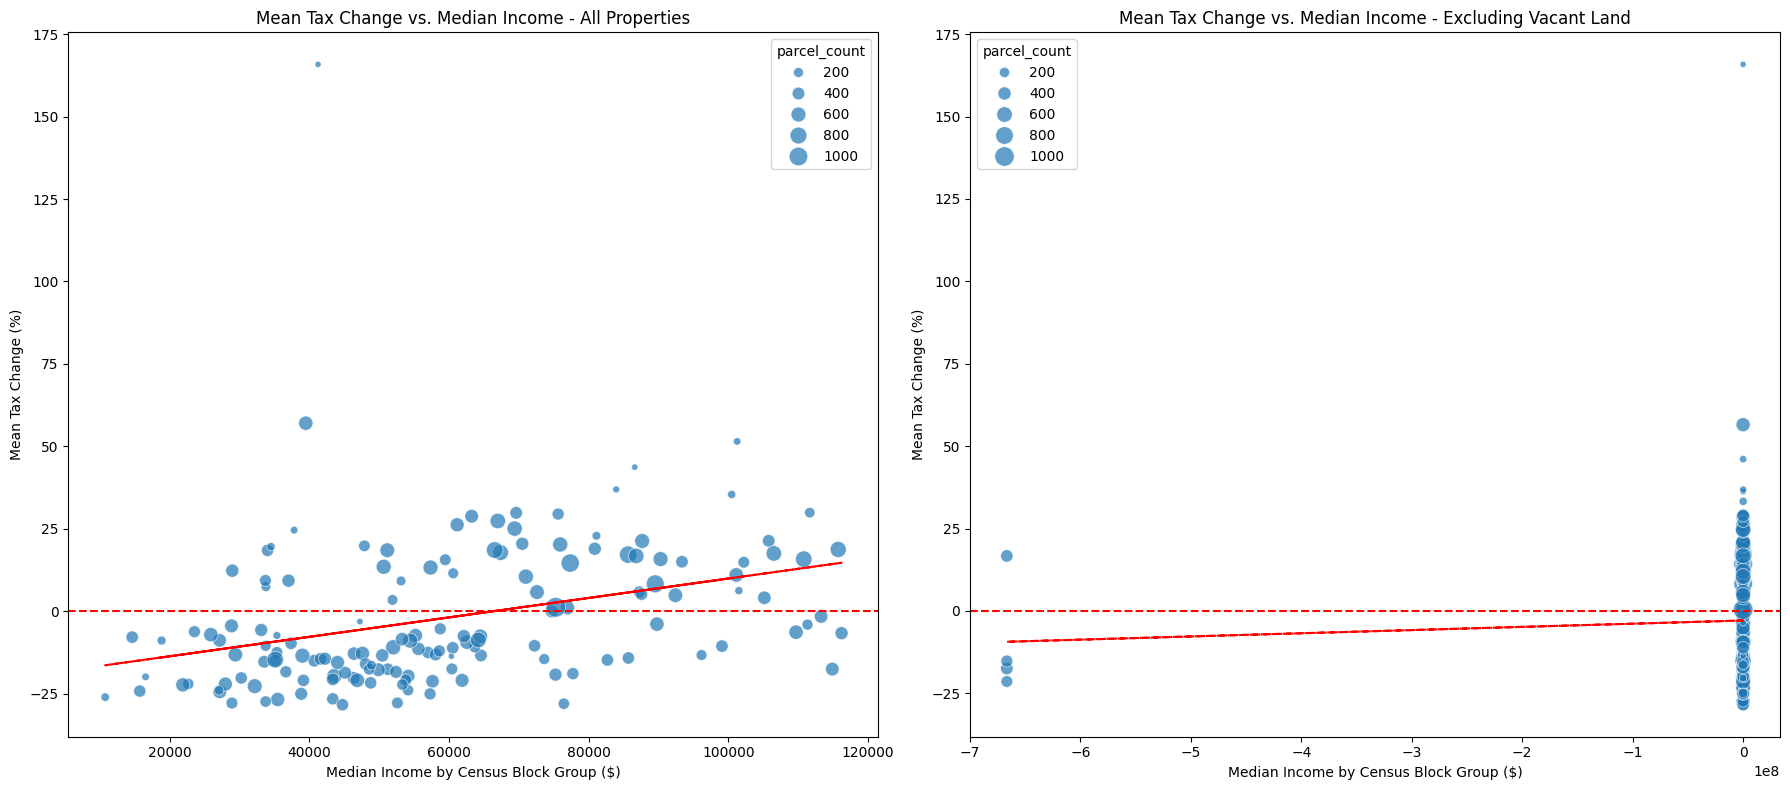

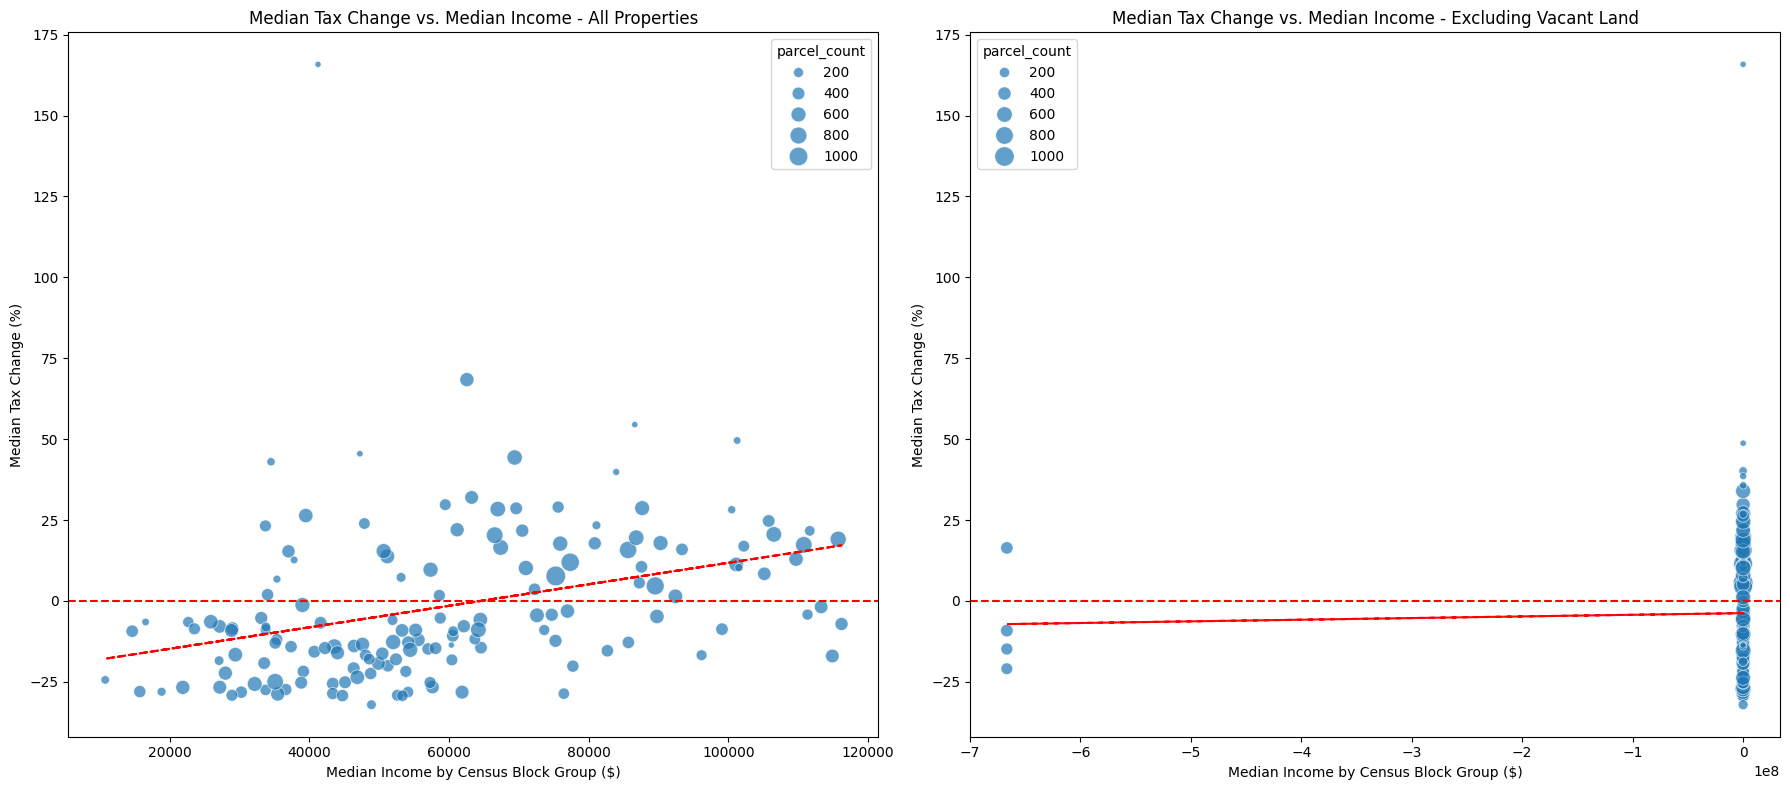

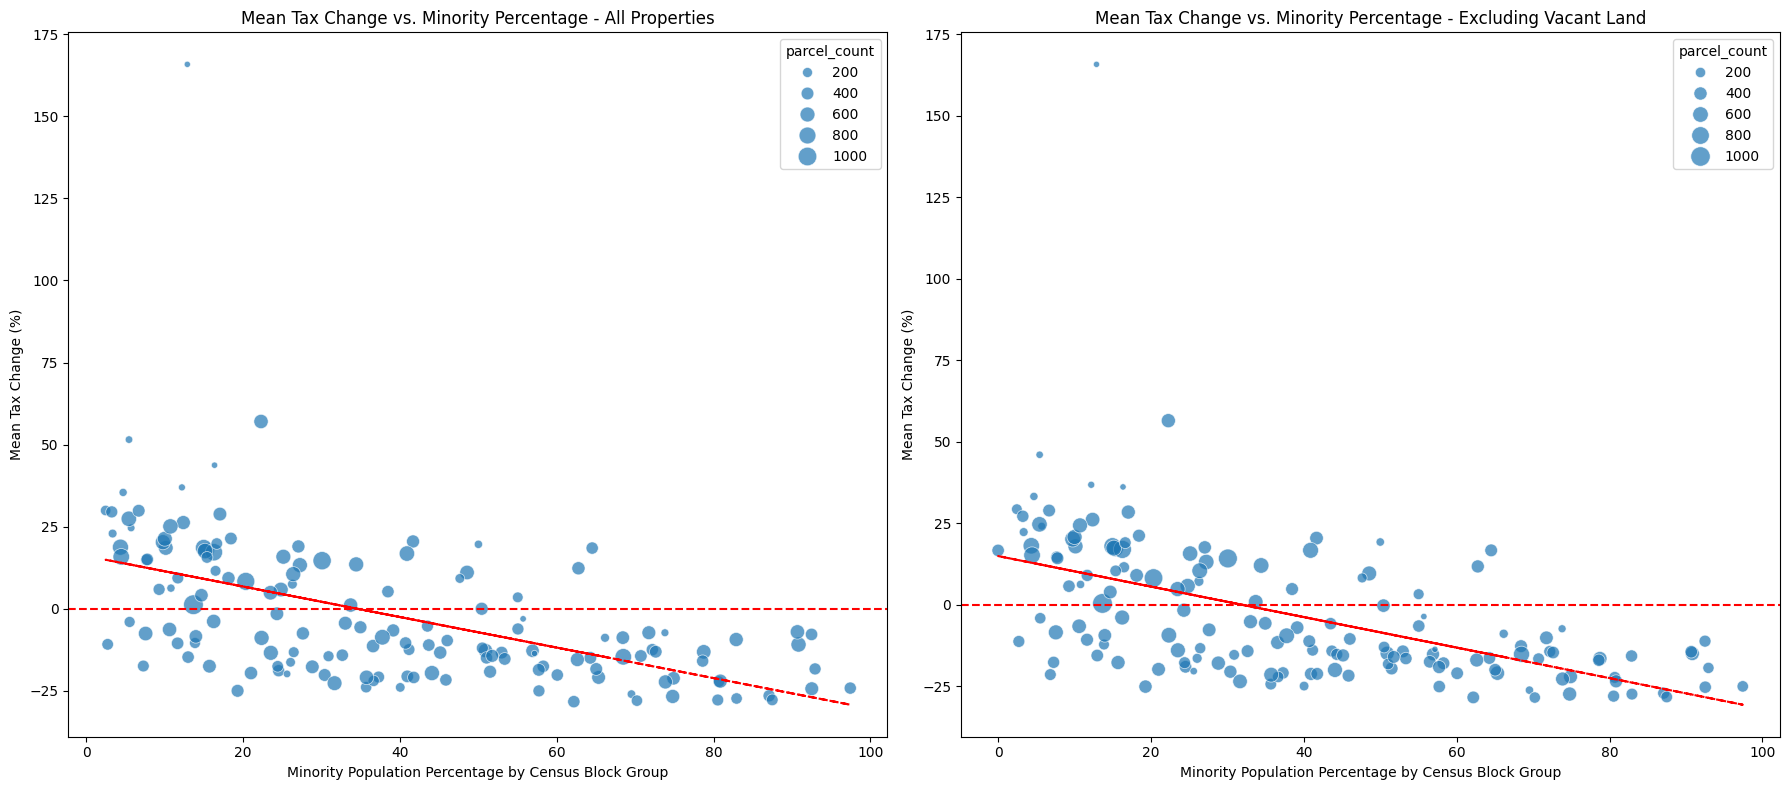

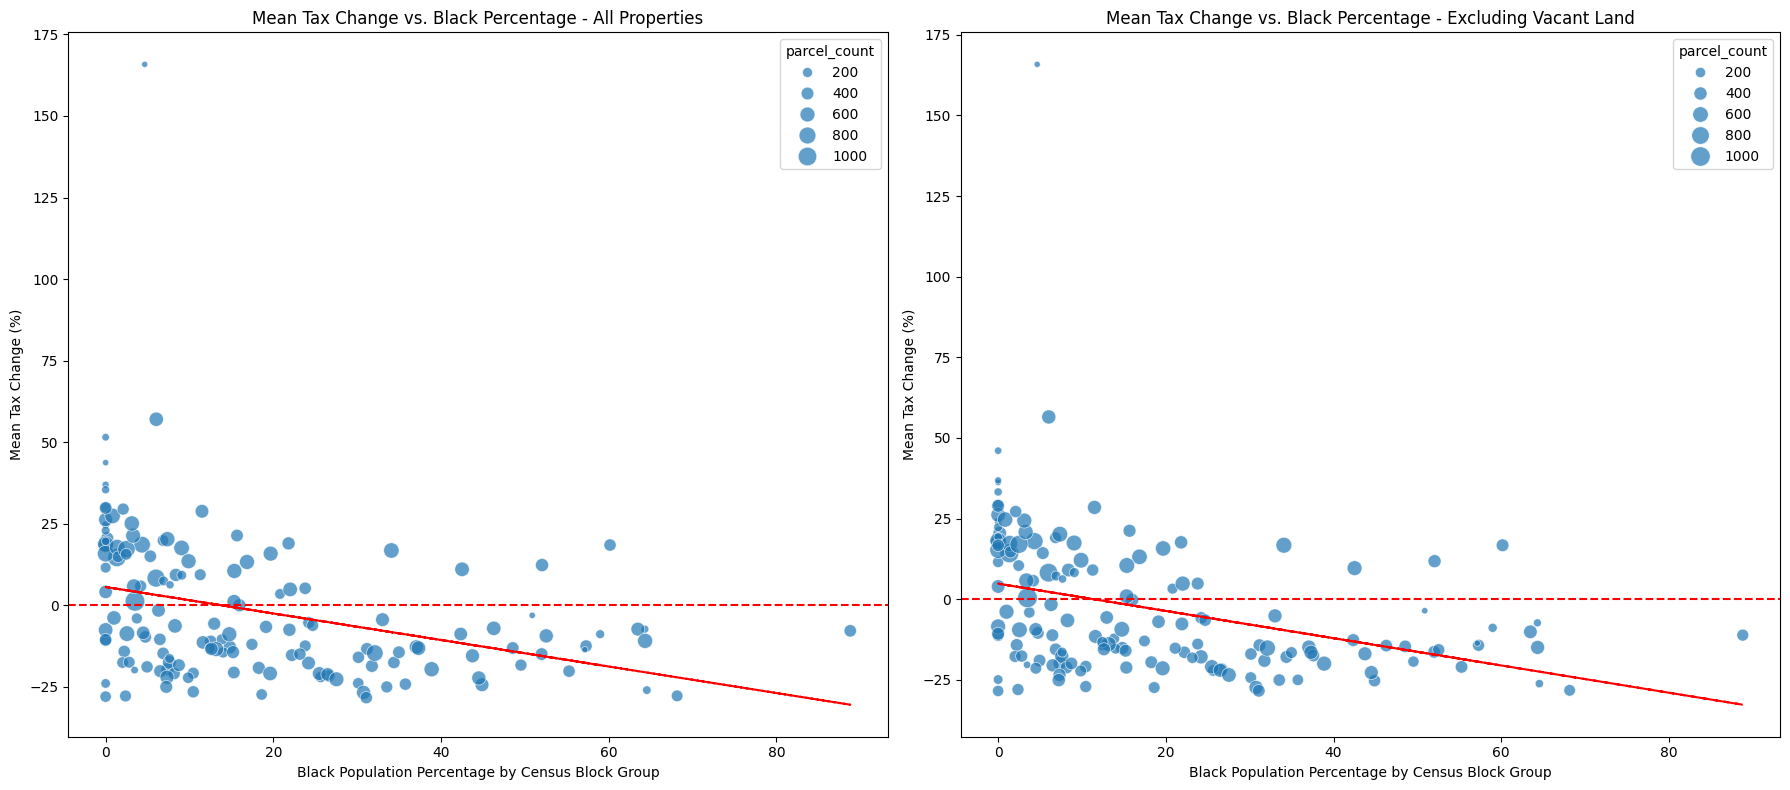

Correlation between median income and mean tax change (all properties): 0.3281
Correlation between median income and mean tax change (excluding vacant land): 0.0450
Correlation between median income and median tax change (all properties): 0.3423
Correlation between median income and median tax change (excluding vacant land): 0.0231
Correlation between minority percentage and mean tax change (all properties): -0.5205
Correlation between minority percentage and mean tax change (excluding vacant land): -0.5296
Correlation between black percentage and mean tax change (all properties): -0.3376
Correlation between black percentage and mean tax change (excluding vacant land): -0.3526

Tax impact by income quintile (all properties):


/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_53463/703420198.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_filtered['income_quintile'] = pd.qcut(gdf_filtered['median_income'], 5, labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"])
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_53463/703420198.py:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_vacant_gdf['income_quintile'] = pd.qcut(non_vacant_gdf['median_income'], 5, labels=["Q1 (Lowest)", "Q2", "Q3", "Q4",

,income_quintile,count,mean_tax_change,median_tax_change,mean_income
0,Q1 (Lowest),12755,-5326.337641,0.0,59442.736842
1,Q2,12719,150.142711,0.0,59442.736842
2,Q3,12446,-1716.496101,0.0,59442.736842
3,Q4,12715,5050.619978,0.0,59442.736842
4,Q5 (Highest),12554,4520.869552,0.0,59442.736842



Tax impact by income quintile (excluding vacant land):


,income_quintile,count,mean_tax_change,median_tax_change,mean_income
0,Q1 (Lowest),12030,-5733.257499,0.0,-4.298244e+06
1,Q2,12030,-276.900822,0.0,-4.298244e+06
2,Q3,11980,-2180.391941,0.0,-4.298244e+06
3,Q4,12066,4436.214650,0.0,-4.298244e+06
4,Q5 (Highest),11744,4560.284782,0.0,-4.298244e+06



Tax impact by minority percentage quintile (all properties):


,minority_quintile,count,mean_tax_change,median_tax_change,mean_minority_pct
0,Q1 (Lowest),13014,81.205907,71.831809,9.025053
1,Q2,12628,92.646046,34.862842,19.538384
2,Q3,12519,-35.342038,-19.831209,33.080983
3,Q4,12441,-56.213440,-38.649674,51.469554
4,Q5 (Highest),12587,-53.847000,-41.246745,78.391301



Tax impact by minority percentage quintile (excluding vacant land):


,minority_quintile,count,mean_tax_change,median_tax_change,mean_minority_pct
0,Q1 (Lowest),12038,82.710124,79.106908,8.306815
1,Q2,11930,85.464087,28.781406,18.632889
2,Q3,12057,-25.638633,-26.055789,31.564235
3,Q4,12035,-71.289773,-41.495858,49.200563
4,Q5 (Highest),11790,-61.479507,-54.117663,76.227169


In [15]:
# 5. Analyze tax impact by census block group median income and demographic characteristics
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter out negative median incomes
gdf_filtered = df[df['median_income'] > 0]

# Create a copy of the dataframe excluding vacant land for tax calculations
non_vacant_gdf = df[df['PROPERTY_CATEGORY'] != 'Vacant Land']
print(f"Number of rows in gdf_filtered: {len(gdf_filtered)}")
print(f"Number of rows in non_vacant_gdf: {len(non_vacant_gdf)}")

# Group by census block group and calculate tax changes for all properties
census_block_groups = gdf_filtered.groupby('std_geoid').agg(
    median_income=('median_income', 'first'),  # Income is the same for each block group
    minority_pct=('minority_pct', 'first'),    # Minority percentage is the same for each block group
    black_pct=('black_pct', 'first'),          # Black percentage is the same for each block group
    total_current_tax=('current_tax', 'sum'),
    total_new_tax=('new_tax', 'sum'),
    mean_tax_change=('TAX_CHANGE', 'mean'),
    median_tax_change=('TAX_CHANGE', 'median'),
    median_tax_change_pct=('TAX_CHANGE_PCT', 'median'),
    parcel_count=('TAX_CHANGE', 'count'),
    has_vacant_land=('PROPERTY_CATEGORY', lambda x: 'Vacant Land' in x.values)
).reset_index()

# Calculate percentage change based on summed values
census_block_groups['mean_tax_change_pct'] = ((census_block_groups['total_new_tax'] - census_block_groups['total_current_tax']) / 
                                             census_block_groups['total_current_tax']) * 100

# Group by census block group and calculate tax changes for non-vacant properties only
non_vacant_block_summary = non_vacant_gdf.groupby('std_geoid').agg(
    median_income=('median_income', 'first'),
    minority_pct=('minority_pct', 'first'),
    black_pct=('black_pct', 'first'),
    total_current_tax=('current_tax', 'sum'),
    total_new_tax=('new_tax', 'sum'),
    mean_tax_change=('TAX_CHANGE', 'mean'),
    median_tax_change=('TAX_CHANGE', 'median'),
    median_tax_change_pct=('TAX_CHANGE_PCT', 'median'),
    parcel_count=('TAX_CHANGE', 'count')
).reset_index()

# Calculate percentage change based on summed values for non-vacant properties
non_vacant_block_summary['mean_tax_change_pct'] = ((non_vacant_block_summary['total_new_tax'] - non_vacant_block_summary['total_current_tax']) / 
                                                  non_vacant_block_summary['total_current_tax']) * 100

# Create a figure with two subplots side by side for mean tax change
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Scatter plot for all census block groups - mean tax change
sns.scatterplot(
    data=census_block_groups,
    x='median_income',
    y='mean_tax_change_pct',
    size='parcel_count',  # Size points by number of parcels
    sizes=(20, 200),
    alpha=0.7,
    ax=ax1
)

# Add a horizontal line at y=0 to show the break-even point
ax1.axhline(y=0, color='r', linestyle='--')

# Add a trend line
x = census_block_groups['median_income'].dropna()
y = census_block_groups['mean_tax_change_pct'].dropna()
mask = ~np.isnan(x) & ~np.isnan(y)
z = np.polyfit(x[mask], y[mask], 1)
p = np.poly1d(z)
ax1.plot(x[mask], p(x[mask]), "r--")

# Set labels and title for the first plot
ax1.set_xlabel('Median Income by Census Block Group ($)')
ax1.set_ylabel('Mean Tax Change (%)')
ax1.set_title('Mean Tax Change vs. Median Income - All Properties')

# Scatter plot for non-vacant properties by block group - mean tax change
sns.scatterplot(
    data=non_vacant_block_summary,
    x='median_income',
    y='mean_tax_change_pct',
    size='parcel_count',  # Size points by number of parcels
    sizes=(20, 200),
    alpha=0.7,
    ax=ax2
)

# Add a horizontal line at y=0 to show the break-even point
ax2.axhline(y=0, color='r', linestyle='--')

# Add a trend line for non-vacant properties
x_nv = non_vacant_block_summary['median_income'].dropna()
y_nv = non_vacant_block_summary['mean_tax_change_pct'].dropna()
mask_nv = ~np.isnan(x_nv) & ~np.isnan(y_nv)
if len(x_nv[mask_nv]) > 1:  # Check if we have enough data points
    z_nv = np.polyfit(x_nv[mask_nv], y_nv[mask_nv], 1)
    p_nv = np.poly1d(z_nv)
    ax2.plot(x_nv[mask_nv], p_nv(x_nv[mask_nv]), "r--")

# Set labels and title for the second plot
ax2.set_xlabel('Median Income by Census Block Group ($)')
ax2.set_ylabel('Mean Tax Change (%)')
ax2.set_title('Mean Tax Change vs. Median Income - Excluding Vacant Land')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Create a figure with two subplots side by side for median tax change
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Scatter plot for all census block groups - median tax change
sns.scatterplot(
    data=census_block_groups,
    x='median_income',
    y='median_tax_change_pct',
    size='parcel_count',  # Size points by number of parcels
    sizes=(20, 200),
    alpha=0.7,
    ax=ax1
)

# Add a horizontal line at y=0 to show the break-even point
ax1.axhline(y=0, color='r', linestyle='--')

# Add a trend line
x = census_block_groups['median_income'].dropna()
y = census_block_groups['median_tax_change_pct'].dropna()
mask = ~np.isnan(x) & ~np.isnan(y)
z = np.polyfit(x[mask], y[mask], 1)
p = np.poly1d(z)
ax1.plot(x[mask], p(x[mask]), "r--")

# Set labels and title for the first plot
ax1.set_xlabel('Median Income by Census Block Group ($)')
ax1.set_ylabel('Median Tax Change (%)')
ax1.set_title('Median Tax Change vs. Median Income - All Properties')

# Scatter plot for non-vacant properties by block group - median tax change
sns.scatterplot(
    data=non_vacant_block_summary,
    x='median_income',
    y='median_tax_change_pct',
    size='parcel_count',  # Size points by number of parcels
    sizes=(20, 200),
    alpha=0.7,
    ax=ax2
)

# Add a horizontal line at y=0 to show the break-even point
ax2.axhline(y=0, color='r', linestyle='--')

# Add a trend line for non-vacant properties
x_nv = non_vacant_block_summary['median_income'].dropna()
y_nv = non_vacant_block_summary['median_tax_change_pct'].dropna()
mask_nv = ~np.isnan(x_nv) & ~np.isnan(y_nv)
if len(x_nv[mask_nv]) > 1:  # Check if we have enough data points
    z_nv = np.polyfit(x_nv[mask_nv], y_nv[mask_nv], 1)
    p_nv = np.poly1d(z_nv)
    ax2.plot(x_nv[mask_nv], p_nv(x_nv[mask_nv]), "r--")

# Set labels and title for the second plot
ax2.set_xlabel('Median Income by Census Block Group ($)')
ax2.set_ylabel('Median Tax Change (%)')
ax2.set_title('Median Tax Change vs. Median Income - Excluding Vacant Land')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Create a figure with two subplots side by side for minority percentage vs tax change
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Scatter plot for all census block groups - mean tax change vs minority percentage
sns.scatterplot(
    data=census_block_groups,
    x='minority_pct',
    y='mean_tax_change_pct',
    size='parcel_count',  # Size points by number of parcels
    sizes=(20, 200),
    alpha=0.7,
    ax=ax1
)

# Add a horizontal line at y=0 to show the break-even point
ax1.axhline(y=0, color='r', linestyle='--')

# Add a trend line
x = census_block_groups['minority_pct'].dropna()
y = census_block_groups['mean_tax_change_pct'].dropna()
mask = ~np.isnan(x) & ~np.isnan(y)
z = np.polyfit(x[mask], y[mask], 1)
p = np.poly1d(z)
ax1.plot(x[mask], p(x[mask]), "r--")

# Set labels and title for the first plot
ax1.set_xlabel('Minority Population Percentage by Census Block Group')
ax1.set_ylabel('Mean Tax Change (%)')
ax1.set_title('Mean Tax Change vs. Minority Percentage - All Properties')

# Scatter plot for non-vacant properties by block group - mean tax change vs minority percentage
sns.scatterplot(
    data=non_vacant_block_summary,
    x='minority_pct',
    y='mean_tax_change_pct',
    size='parcel_count',  # Size points by number of parcels
    sizes=(20, 200),
    alpha=0.7,
    ax=ax2
)

# Add a horizontal line at y=0 to show the break-even point
ax2.axhline(y=0, color='r', linestyle='--')

# Add a trend line for non-vacant properties
x_nv = non_vacant_block_summary['minority_pct'].dropna()
y_nv = non_vacant_block_summary['mean_tax_change_pct'].dropna()
mask_nv = ~np.isnan(x_nv) & ~np.isnan(y_nv)
if len(x_nv[mask_nv]) > 1:  # Check if we have enough data points
    z_nv = np.polyfit(x_nv[mask_nv], y_nv[mask_nv], 1)
    p_nv = np.poly1d(z_nv)
    ax2.plot(x_nv[mask_nv], p_nv(x_nv[mask_nv]), "r--")

# Set labels and title for the second plot
ax2.set_xlabel('Minority Population Percentage by Census Block Group')
ax2.set_ylabel('Mean Tax Change (%)')
ax2.set_title('Mean Tax Change vs. Minority Percentage - Excluding Vacant Land')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Create a figure with two subplots side by side for black percentage vs tax change
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Scatter plot for all census block groups - mean tax change vs black percentage
sns.scatterplot(
    data=census_block_groups,
    x='black_pct',
    y='mean_tax_change_pct',
    size='parcel_count',  # Size points by number of parcels
    sizes=(20, 200),
    alpha=0.7,
    ax=ax1
)

# Add a horizontal line at y=0 to show the break-even point
ax1.axhline(y=0, color='r', linestyle='--')

# Add a trend line
x = census_block_groups['black_pct'].dropna()
y = census_block_groups['mean_tax_change_pct'].dropna()
mask = ~np.isnan(x) & ~np.isnan(y)
z = np.polyfit(x[mask], y[mask], 1)
p = np.poly1d(z)
ax1.plot(x[mask], p(x[mask]), "r--")

# Set labels and title for the first plot
ax1.set_xlabel('Black Population Percentage by Census Block Group')
ax1.set_ylabel('Mean Tax Change (%)')
ax1.set_title('Mean Tax Change vs. Black Percentage - All Properties')

# Scatter plot for non-vacant properties by block group - mean tax change vs black percentage
sns.scatterplot(
    data=non_vacant_block_summary,
    x='black_pct',
    y='mean_tax_change_pct',
    size='parcel_count',  # Size points by number of parcels
    sizes=(20, 200),
    alpha=0.7,
    ax=ax2
)

# Add a horizontal line at y=0 to show the break-even point
ax2.axhline(y=0, color='r', linestyle='--')

# Add a trend line for non-vacant properties
x_nv = non_vacant_block_summary['black_pct'].dropna()
y_nv = non_vacant_block_summary['mean_tax_change_pct'].dropna()
mask_nv = ~np.isnan(x_nv) & ~np.isnan(y_nv)
if len(x_nv[mask_nv]) > 1:  # Check if we have enough data points
    z_nv = np.polyfit(x_nv[mask_nv], y_nv[mask_nv], 1)
    p_nv = np.poly1d(z_nv)
    ax2.plot(x_nv[mask_nv], p_nv(x_nv[mask_nv]), "r--")

# Set labels and title for the second plot
ax2.set_xlabel('Black Population Percentage by Census Block Group')
ax2.set_ylabel('Mean Tax Change (%)')
ax2.set_title('Mean Tax Change vs. Black Percentage - Excluding Vacant Land')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Calculate correlation between median income and tax change percentage
correlation_all_mean = census_block_groups[['median_income', 'mean_tax_change_pct']].corr().iloc[0, 1]
correlation_non_vacant_mean = non_vacant_block_summary[['median_income', 'mean_tax_change_pct']].corr().iloc[0, 1]
correlation_all_median = census_block_groups[['median_income', 'median_tax_change_pct']].corr().iloc[0, 1]
correlation_non_vacant_median = non_vacant_block_summary[['median_income', 'median_tax_change_pct']].corr().iloc[0, 1]

# Calculate correlation between minority percentage and tax change percentage
correlation_minority_all_mean = census_block_groups[['minority_pct', 'mean_tax_change_pct']].corr().iloc[0, 1]
correlation_minority_non_vacant_mean = non_vacant_block_summary[['minority_pct', 'mean_tax_change_pct']].corr().iloc[0, 1]

# Calculate correlation between black percentage and tax change percentage
correlation_black_all_mean = census_block_groups[['black_pct', 'mean_tax_change_pct']].corr().iloc[0, 1]
correlation_black_non_vacant_mean = non_vacant_block_summary[['black_pct', 'mean_tax_change_pct']].corr().iloc[0, 1]

print(f"Correlation between median income and mean tax change (all properties): {correlation_all_mean:.4f}")
print(f"Correlation between median income and mean tax change (excluding vacant land): {correlation_non_vacant_mean:.4f}")
print(f"Correlation between median income and median tax change (all properties): {correlation_all_median:.4f}")
print(f"Correlation between median income and median tax change (excluding vacant land): {correlation_non_vacant_median:.4f}")
print(f"Correlation between minority percentage and mean tax change (all properties): {correlation_minority_all_mean:.4f}")
print(f"Correlation between minority percentage and mean tax change (excluding vacant land): {correlation_minority_non_vacant_mean:.4f}")
print(f"Correlation between black percentage and mean tax change (all properties): {correlation_black_all_mean:.4f}")
print(f"Correlation between black percentage and mean tax change (excluding vacant land): {correlation_black_non_vacant_mean:.4f}")

# Create summary statistics by income quintiles
gdf_filtered['income_quintile'] = pd.qcut(gdf_filtered['median_income'], 5, labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"])
non_vacant_gdf['income_quintile'] = pd.qcut(non_vacant_gdf['median_income'], 5, labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"])

# Create summary statistics by minority percentage quintiles
gdf_filtered['minority_quintile'] = pd.qcut(gdf_filtered['minority_pct'], 5, labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"])
non_vacant_gdf['minority_quintile'] = pd.qcut(non_vacant_gdf['minority_pct'], 5, labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"])

# Collapse data to census block group level, summing the tax changes
# For all properties
census_block_summary = gdf_filtered.groupby(['income_quintile', 'median_income']).agg(
    total_tax_change=('TAX_CHANGE', 'sum'),
    parcel_count=('TAX_CHANGE', 'count')
).reset_index()

# For non-vacant properties
non_vacant_census_block_summary = non_vacant_gdf.groupby(['income_quintile', 'median_income']).agg(
    total_tax_change=('TAX_CHANGE', 'sum'),
    parcel_count=('TAX_CHANGE', 'count')
).reset_index()

# Summary for all properties by income quintile
income_quintile_summary = census_block_summary.groupby('income_quintile').agg(
    count=('parcel_count', 'sum'),
    mean_tax_change=('total_tax_change', 'mean'),
    median_tax_change=('total_tax_change', 'median'),
    mean_income=('median_income', 'mean')
).reset_index()

# Summary for non-vacant properties by income quintile
non_vacant_income_quintile_summary = non_vacant_census_block_summary.groupby('income_quintile').agg(
    count=('parcel_count', 'sum'),
    mean_tax_change=('total_tax_change', 'mean'),
    median_tax_change=('total_tax_change', 'median'),
    mean_income=('median_income', 'mean')
).reset_index()

# Summary for all properties by minority percentage quintile
minority_quintile_summary = gdf_filtered.groupby('minority_quintile').agg(
    count=('TAX_CHANGE', 'count'),
    mean_tax_change=('TAX_CHANGE', 'mean'),
    median_tax_change=('TAX_CHANGE', 'median'),
    mean_minority_pct=('minority_pct', 'mean')
).reset_index()

# Summary for non-vacant properties by minority percentage quintile
non_vacant_minority_quintile_summary = non_vacant_gdf.groupby('minority_quintile').agg(
    count=('TAX_CHANGE', 'count'),
    mean_tax_change=('TAX_CHANGE', 'mean'),
    median_tax_change=('TAX_CHANGE', 'median'),
    mean_minority_pct=('minority_pct', 'mean')
).reset_index()

print("\nTax impact by income quintile (all properties):")
display(income_quintile_summary)

print("\nTax impact by income quintile (excluding vacant land):")
display(non_vacant_income_quintile_summary)

print("\nTax impact by minority percentage quintile (all properties):")
display(minority_quintile_summary)

print("\nTax impact by minority percentage quintile (excluding vacant land):")
display(non_vacant_minority_quintile_summary)
